# **Redes Neuronales (Fundamento de los sistemas operativos)**

---

Este proyecto ha sido desarrollado por Helen González Báez, Cristian Tomás Vega Appelqvist y Alejandro José Martel Torres. Para el desarrollo de los scripts nos hemos apoyado en los fundamentos explicados en clase, los *Jupyter Notebooks* de prácticas y la ayuda de Gemini en el planteamiento de algunas decisiones.


El desarrollo de las cinco red neuronales de este proyecto comparten  librerías de implementación común; por tanto, con el fin de no crear repeticiones explicaremos a continunación las que se han utilizado. En primer lugar, para implementar las redes hemos usado  **PyTorch** para clasificar las imágenes del conjunto de subcarpetas localizadas en la carpeta **dataset3**, os para interactuar con el sistema operativo y poder localizar el conjunto sin necesidad de rutas absolutas, PIP para poder manipular las imágenes, sklearn.metrics para generar la matriz de confusión, seaborn para crear el mapa de calor, matplotilb.pyplot para generar las gráficas y numpy para el tratamiento vectorial. Asimismo, las imágenes cargadas se reescalan a un tamaño de 224x224, para convertirlas en tensores, es decir, matrices que representan numéricamente los píxeles de cada imagen.

Esta red utiliza el modelo preentrenado ConvNeXt Tiny, una estructura que moderniza la arquitectura convolucional clásica basada en ResNet-50 al integrar la eficiencia de las CNNs con características de los Transformers, como el uso de kernels de 7x7, bloques Inverted Bottleneck y componentes como LayerNorm y GELU. Asimismo, hemos aplicado una estrategia de transfer learning, modificando la capa final para adaptarla a nuestro problema mediante una capa lineal con 4 salidas, logrando una tasa de éxito del 98.81%. A continuación, se muestran los resultados obtenidos:


                                                 GRÁFICAS Y MAPA DE CALOR


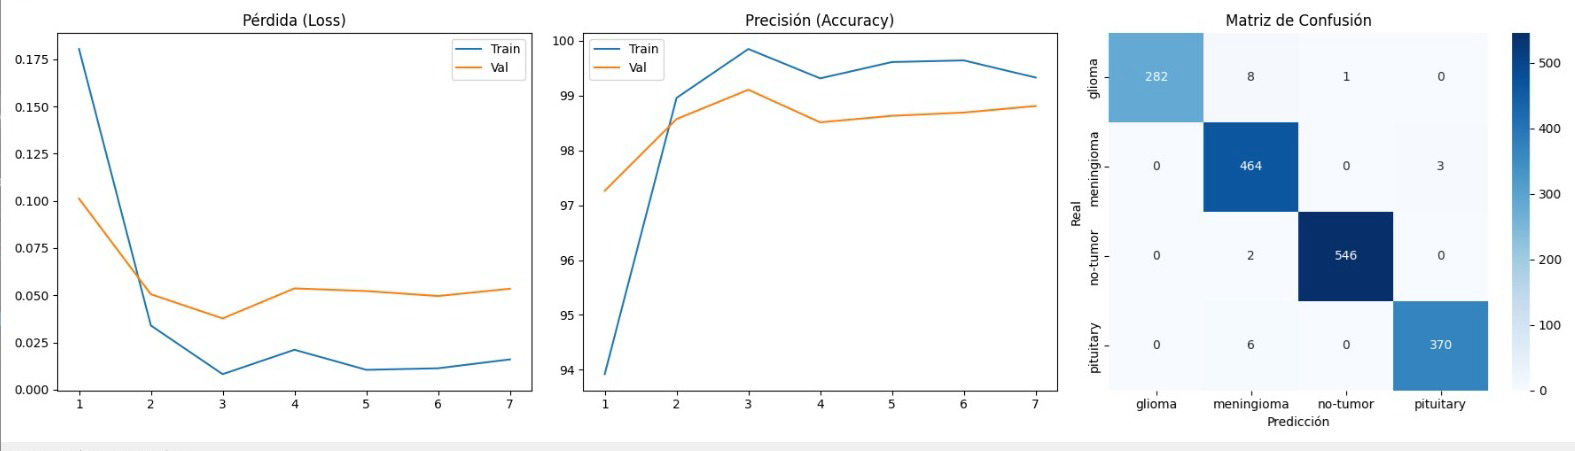

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
# Importamos convnext especificamente
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os

# --- LIBRERÍAS DE VISUALIZACIÓN ---
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Carga del dataset
data_dir = "dataset"

# Transformacion (Standard ImageNet)
transformacion_comun = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Cargar dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transformacion_comun)

# ================================Imprime los 4 tipos de tumores (completamente borrable)==============================
classes = full_dataset.classes
NUM_CLASSES = len(classes)
print(f"Dataset cargado. {NUM_CLASSES} Clases encontradas: {classes}")
# =====================================================================================================================

# Dividir dataset (80% train, 20% val)
n_pictures_train = int(0.8 * len(full_dataset))
n_pictures_valid = len(full_dataset) - n_pictures_train
train_dataset, val_dataset = random_split(full_dataset, [n_pictures_train, n_pictures_valid])


# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

# =========================================================================
#  ZONA DE FUNCIONES REUTILIZABLES
# =========================================================================

def evaluate(model, test_loader):
    """Calcula la precisión (accuracy) de forma rápida."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total if total > 0 else 0.0

def train_with_validation(model, train_loader, dev_loader, criterion, optimizer, epochs=5):
    """Entrena el modelo y guarda el historial de Loss/Acc."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': []}

    print(f"Iniciando entrenamiento en: {device}")

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Métricas
        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # Validación
        model.eval()
        dev_loss_acc = 0.0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                dev_loss_acc += criterion(outputs, labels).item()

        avg_dev_loss = dev_loss_acc / len(dev_loader)
        dev_acc = evaluate(model, dev_loader)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        print(f'[Epoch {epoch + 1}] Train Loss: {avg_train_loss:.3f} | Train Acc: {train_acc:.2f}% | Val Acc: {dev_acc:.2f}%')

    return model, history

def analizar_resultados(model, history, test_loader, classes):
    """
    Función 'Todo en Uno': Dibuja Loss, Accuracy y Matriz de Confusión.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    plt.figure(figsize=(18, 5))

    # 1. Gráfica Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['dev_loss'], label='Val')
    plt.title('Pérdida (Loss)'); plt.legend()

    # 2. Gráfica Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['dev_acc'], label='Val')
    plt.title('Precisión (Accuracy)'); plt.legend()

    # 3. Matriz de Confusión
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión')
    plt.ylabel('Real'); plt.xlabel('Predicción')

    plt.tight_layout()
    plt.show()

# =========================================================================

# --- 2. MODELO (ConvNeXt) ---
weights = ConvNeXt_Tiny_Weights.DEFAULT # Coje los conociemientos d la IA ConvNeXt
model = convnext_tiny(weights=weights) # Crea una red neuronal copiando ConvNeXt

# Modificar la última capa para el número correcto de clases
# ConvNeXt tiene la estructura: model.classifier[2] es la capa lineal final
num_ftrs = model.classifier[2].in_features # Lee cuantas neuronas hay en la última capa
model.classifier[2] = nn.Linear(num_ftrs, NUM_CLASSES) # Cambia ese nº d neuronas x las 4 q hacen falta

# Detecta si hay GPU y la usa en caso afirmativo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
model = model.to(device)

# Establece el criterio de entrenamiento y la velocidad de aprendizaje
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- 3. ENTRENAMIENTO (Usando las funciones nuevas) ---
# Ejecutamos el entrenamiento y guardamos el historial
model_entrenado, historial = train_with_validation(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=7
)



# --- 4. ANÁLISIS VISUAL ---
# Genera las gráficas y la matriz de confusión automáticamente
analizar_resultados(model_entrenado, historial, val_loader, classes)

# --- 5. GUARDAR Y PROBAR ---
torch.save(model_entrenado.state_dict(), "ia_tumors01 ConvNeXt.pth")
print("\nModelo guardado correctamente.")


Esta segunda red neuronal ha sido desarrollada sin utilizar transferencia de aprendizaje, empleando funciones de la clásica librería **PyTorch** para clasificar las imágenes del conjunto de subcarpetas localizadas en la carpeta **dataset3**. Las imágenes cargadas se reescalan a un tamaño de 224x224, para convertirlas en tensores, es decir, matrices que representan numéricamente los píxeles de cada imagen que se aplican como modificaciones al conjunto de entrenamiento y validación.

Siguiendo el flujo del código se presenta el núcleo del código que actúa como cerebro, la clase **SimpleNet** que contiene a la red neuronal, seguido de la función de evaluación del aprendizaje y la función de entrenamiento. Una vez finalizado el entrenamineto y los cálculos de evaluación tiene lugar la graficación donde se puede observar la trayectoria y evolución de la red. Asimismo, mediante el mapa de calor también podemos observar cuantas veces se confundieron las imágenes y con qué otras clases las relacionó, la tasa de éxito final que tiene el modelo es del 95.24%. Finalmente, se detallan las características de la red neuronal SimpleNet, que se estructura en dos bloques:

El primer bloque, self.features() es un extractor de características aplicando cuatro capas de convolución. En cada capa se duplica la profundidad de los canales obteniendo más características, evitándose no-linealidad con la función de activación ReLU, función estándar en la actualidad en redes neuronales.

Por otro lado, el bloque self.classifier es el que hace la clasificación final de las imágenes. Este bloque transforma el tensor en un vector lineal y utiliza una capa de Dropout apagando la mitad de las neuronas aleatoriamente mejorando el aprendizaje. A continuación, se presentan la matriz de confusión y las gráficas del análisis evolutivo.


                                                            GRÁFICA

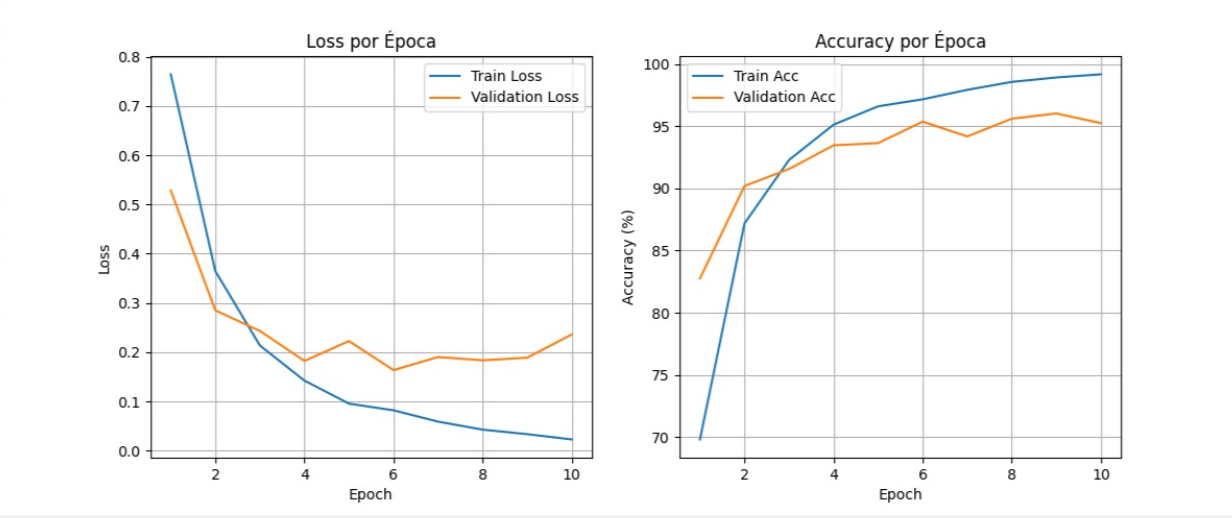



                                                      MATRIZ DE CONFUSIÓN


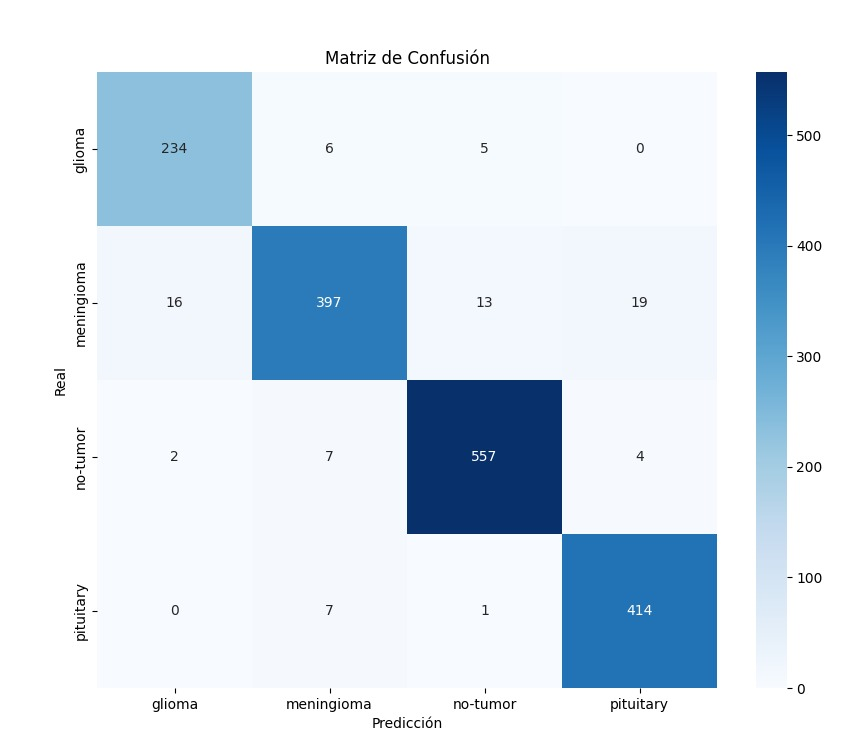

In [ ]:
# --- LIBRERIAS NECESARIAS PARA EL DESARROLLO RED NEURONAL ---
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---
data_dir = "dataset"

# Transformaciones
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Cálculo dinámico de clases
classes = full_dataset.classes
NUM_CLASSES = len(classes)
print(f"Dataset cargado. {NUM_CLASSES} Clases encontradas: {classes}")

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Aplicar transformación de validación
val_dataset.dataset.transform = val_transform

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("-" * 30)

# --- 2. DEFINICIÓN DEL MODELO (SimpleNet) ---
class SimpleNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = SimpleNet(NUM_CLASSES)

# --- 3. TUS FUNCIONES INTEGRADAS ---

def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = len(test_loader.dataset) # Forma segura de obtener longitud

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total if total > 0 else 0.0
    return accuracy

def train_with_validation(model, train_loader, dev_loader, criterion, optimizer, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    history = {'train_loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': []}

    print(f"Iniciando entrenamiento en: {device}")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            n_classes = outputs.shape[1]
            labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()
            loss = criterion(outputs, labels_one_hot)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # Validación (loss)
        model.eval()
        dev_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                n_classes = outputs.shape[1]
                labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()
                dev_loss = criterion(outputs, labels_one_hot)
                dev_running_loss += dev_loss.item()

        avg_dev_loss = dev_running_loss / len(dev_loader)

        # Validación usando la función evaluate (medida de precisión)
        dev_acc = evaluate(model, dev_loader)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        print(f'[Epoch {epoch + 1}] train_loss: {avg_train_loss:.3f} | train_acc: {train_acc:.2f}% | dev_loss: {avg_dev_loss:.3f} | dev_acc: {dev_acc:.2f}%')

    return model, history

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['dev_loss'], label='Validation Loss')
    plt.title('Loss por Época')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['dev_acc'], label='Validation Acc')
    plt.title('Accuracy por Época')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.show()

# --- 4. EJECUCIÓN PRINCIPAL ---

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ENTRENAR USANDO TUS FUNCIONES
model_entrenado, history = train_with_validation(
    model,
    train_loader,
    val_loader, # Pasamos val_loader como 'dev_loader'
    criterion,
    optimizer,
    epochs=10
)

# GRAFICAR RESULTADOS
plot_training_history(history)

# --- 5. MATRIZ DE CONFUSIÓN ---
print("-" * 30)
print("Generando Matriz de Confusión Final...")

model_entrenado.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    # Usamos val_loader porque no tenemos test_loader separado
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_entrenado(inputs)
        _, predicted = torch.max(outputs, 1)

        # Mover a CPU para numpy
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generar la matriz
cm = confusion_matrix(all_labels, all_preds)

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Guardar Modelo
torch.save(model_entrenado.state_dict(), "simple_cnn_final.pth")
print("Modelo guardado exitosamente.")

Este tercer bloque de código comparte una implementación equivalente a la del anterior, teniendo como cambio la implementación de la red neuronal, en la que se reduce a la mitad el número de canales de salida y, por tanto, se obtiene menos característica durante el procesamiento. Esto hace que el modelo sea mucho más ligero en procesamiento, aunque aumenta el riesgo de imprecisión en la clasificación, la tasa de éxito final del modelo fue del 95.78%. En las siguientes imágenes se puede observar el comportamiento en las gráficas evolutivas y en el mapa de calor:


                                                      GRÁFICAS Y MAPA DE CALOR

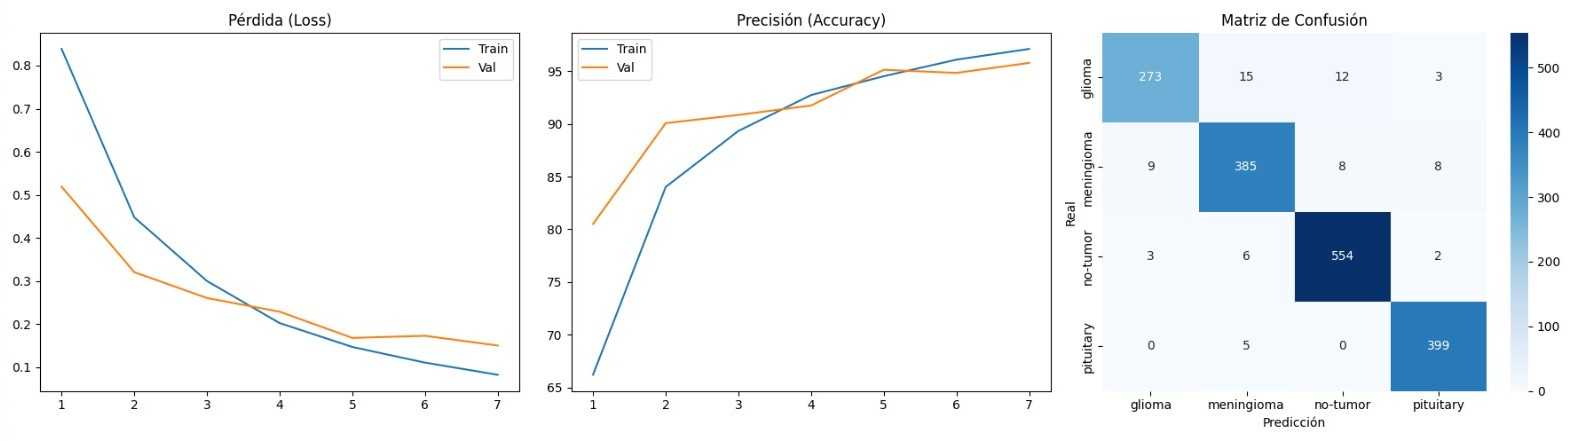

In [ ]:
# Código 3
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuración del Dataset ---
data_dir = "dataset"

# --- 1. Transformaciones ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 2. Carga y División ---
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
classes = full_dataset.classes
NUM_CLASSES = len(classes)
print(f"Dataset cargado. {NUM_CLASSES} Clases: {classes}")

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Cambio de transformación para validación
val_dataset.dataset.transform = val_transform

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("-" * 30)

# --- 3. Definición del Modelo ---
class CNN_Minimalista(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_Minimalista, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = CNN_Minimalista(NUM_CLASSES)

# =========================================================================
#  ZONA DE FUNCIONES REUTILIZABLES (COPIAR Y PEGAR EN OTRAS IAs)
# =========================================================================

def evaluate(model, test_loader):
    """Calcula la precisión (accuracy) de forma rápida."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total if total > 0 else 0.0

def train_with_validation(model, train_loader, dev_loader, criterion, optimizer, epochs=5):
    """Entrena el modelo y guarda el historial de Loss/Acc."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': []}

    print(f"Iniciando entrenamiento en: {device}")

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Cálculo de Loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Métricas de la época
        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # Validación
        model.eval()
        dev_loss_acc = 0.0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                dev_loss_acc += criterion(outputs, labels).item()

        avg_dev_loss = dev_loss_acc / len(dev_loader)
        dev_acc = evaluate(model, dev_loader)

        # Guardar historial
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        print(f'[Epoch {epoch + 1}] Train Loss: {avg_train_loss:.3f} | Train Acc: {train_acc:.2f}% | Val Acc: {dev_acc:.2f}%')

    return model, history

def analizar_resultados(model, history, test_loader, classes):
    """
    Función 'Todo en Uno': Dibuja Loss, Accuracy y Matriz de Confusión.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    plt.figure(figsize=(18, 5))

    # 1. Gráfica Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['dev_loss'], label='Val')
    plt.title('Pérdida (Loss)'); plt.legend()

    # 2. Gráfica Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['dev_acc'], label='Val')
    plt.title('Precisión (Accuracy)'); plt.legend()

    # 3. Matriz de Confusión
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión')
    plt.ylabel('Real'); plt.xlabel('Predicción')

    plt.tight_layout()
    plt.show()

# =========================================================================

# --- 4. Configuración y Ejecución ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model_entrenado, historial = train_with_validation(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=7
)

analizar_resultados(model_entrenado, historial, val_loader, classes)

# --- 7. Guardar y Predecir ---
model_save_path = "simple_cnn_model.pth"
torch.save(model_entrenado.state_dict(), model_save_path)
print(f"\nModelo guardado en: {model_save_path}")

# Ejemplo de predicción
img_path = os.path.join(data_dir, classes[0], "G_1_BR.jpg")
if os.path.exists(img_path):
    print(f"Probando predicción con: {img_path}")
    img = Image.open(img_path).convert("RGB")
    x = val_transform(img).unsqueeze(0).to(device)

    model_entrenado.eval()
    with torch.no_grad():
        outputs = model_entrenado(x)
        _, pred = torch.max(outputs, 1)
        print("Predicción:", classes[pred.item()])

Este cuarto bloque de código evoluciona hacia una estructura más robusta y modular, encapsulando el ciclo de entrenamiento y validación en funciones reutilizables. Se implementa la arquitectura CNN_Minimalista, diseñada con una profundidad de canales contenida (iniciando en 8 filtros) para mantener la ligereza computacional y con una capa menos con respecto a la red antrerior. La mejora más significativa es la incorporación de herramientas de análisis visual, lo que permite monitorear el sobreajuste y la precisión de cada clase de forma gráfica, la tasa de éxito final en esta red neuronal fue del 93.88%. En las siguientes imágenes se puede observar el comportamiento en las curvas de aprendizaje (Loss/Accuracy) y el detalle de aciertos en la matriz de confusión:

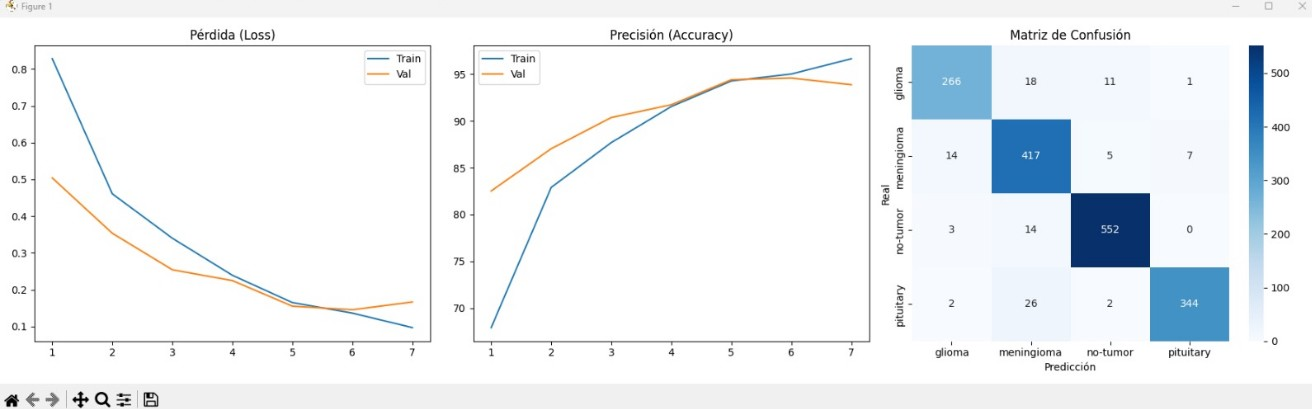

In [ ]:
# Código 4
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os

# --- IMPORTACIONES NUEVAS NECESARIAS ---
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuración del Dataset ---
data_dir = "dataset"
# Ajustaremos num_classes dinámicamente según la carpeta

# --- 1. Transformaciones ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 2. Carga y División ---
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
classes = full_dataset.classes
NUM_CLASSES = len(classes)
print(f"Dataset cargado. {NUM_CLASSES} Clases: {classes}")

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Cambio de transformación para validación
val_dataset.dataset.transform = val_transform

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("-" * 30)

# --- 3. Definición del Modelo ---
class CNN_Minimalista(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_Minimalista, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = CNN_Minimalista(NUM_CLASSES)

# =========================================================================
#  ZONA DE FUNCIONES REUTILIZABLES (COPIAR Y PEGAR EN OTRAS IAs)
# =========================================================================

def evaluate(model, test_loader):
    """Calcula la precisión (accuracy) de forma rápida."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total if total > 0 else 0.0

def train_with_validation(model, train_loader, dev_loader, criterion, optimizer, epochs=5):
    """Entrena el modelo y guarda el historial de Loss/Acc."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': []}

    print(f"Iniciando entrenamiento en: {device}")

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Cálculo de Loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Métricas de la época
        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # Validación
        model.eval()
        dev_loss_acc = 0.0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                dev_loss_acc += criterion(outputs, labels).item()

        avg_dev_loss = dev_loss_acc / len(dev_loader)
        dev_acc = evaluate(model, dev_loader)

        # Guardar historial
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        print(f'[Epoch {epoch + 1}] Train Loss: {avg_train_loss:.3f} | Train Acc: {train_acc:.2f}% | Val Acc: {dev_acc:.2f}%')

    return model, history

def analizar_resultados(model, history, test_loader, classes):
    """
    Función 'Todo en Uno': Dibuja Loss, Accuracy y Matriz de Confusión.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    plt.figure(figsize=(18, 5))

    # 1. Gráfica Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['dev_loss'], label='Val')
    plt.title('Pérdida (Loss)'); plt.legend()

    # 2. Gráfica Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['dev_acc'], label='Val')
    plt.title('Precisión (Accuracy)'); plt.legend()

    # 3. Matriz de Confusión
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión')
    plt.ylabel('Real'); plt.xlabel('Predicción')

    plt.tight_layout()
    plt.show()

# =========================================================================

# --- 4. Configuración y Ejecución ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- AQUI ESTÁ EL CAMBIO PRINCIPAL ---
# En lugar de tu bucle 'for' manual, usamos la función que guarda el historial
model_entrenado, historial = train_with_validation(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=7
)

# --- LLAMADA A LA FUNCIÓN MÁGICA ---
analizar_resultados(model_entrenado, historial, val_loader, classes)

# --- 7. Guardar y Predecir ---
model_save_path = "simple_cnn_model.pth"
torch.save(model_entrenado.state_dict(), model_save_path)
print(f"\nModelo guardado en: {model_save_path}")

# Ejemplo de predicción
img_path = os.path.join(data_dir, classes[0], "G_1_BR.jpg")
if os.path.exists(img_path):
    print(f"Probando predicción con: {img_path}")
    img = Image.open(img_path).convert("RGB")
    x = val_transform(img).unsqueeze(0).to(device)

    model_entrenado.eval()
    with torch.no_grad():
        outputs = model_entrenado(x)
        _, pred = torch.max(outputs, 1)
        print("Predicción:", classes[pred.item()])

Este quinto bloque de código presenta una arquitectura más sofisticada denominada CNN_Modificada, introduciendo cambios estructurales profundos respecto a las versiones anteriores. Consta nuevamente de 4 capas a las que implementamos Batch Normalization para estabilizar la entrada en cada etapa y se sustituye la función de activación estándar (ReLU) por Tanh, lo que altera significativamente la dinámica de los gradientes durante el aprendizaje. Además, se cambia la estrategia de optimización utilizando SGD con Momentum e introduciendo rotación en el aumento de datos, priorizando la robustez y generalización del modelo sobre la velocidad de convergencia y con scheduler maximizamos el aprendizaje en los últimos pasos, para evitar que se confunda el modelo.

En este caso la tasa de éxito tras siete épocas fue del 89.66%. En las siguientes imágenes se puede observar el impacto de la función Tanh y la normalización en las curvas de entrenamiento:

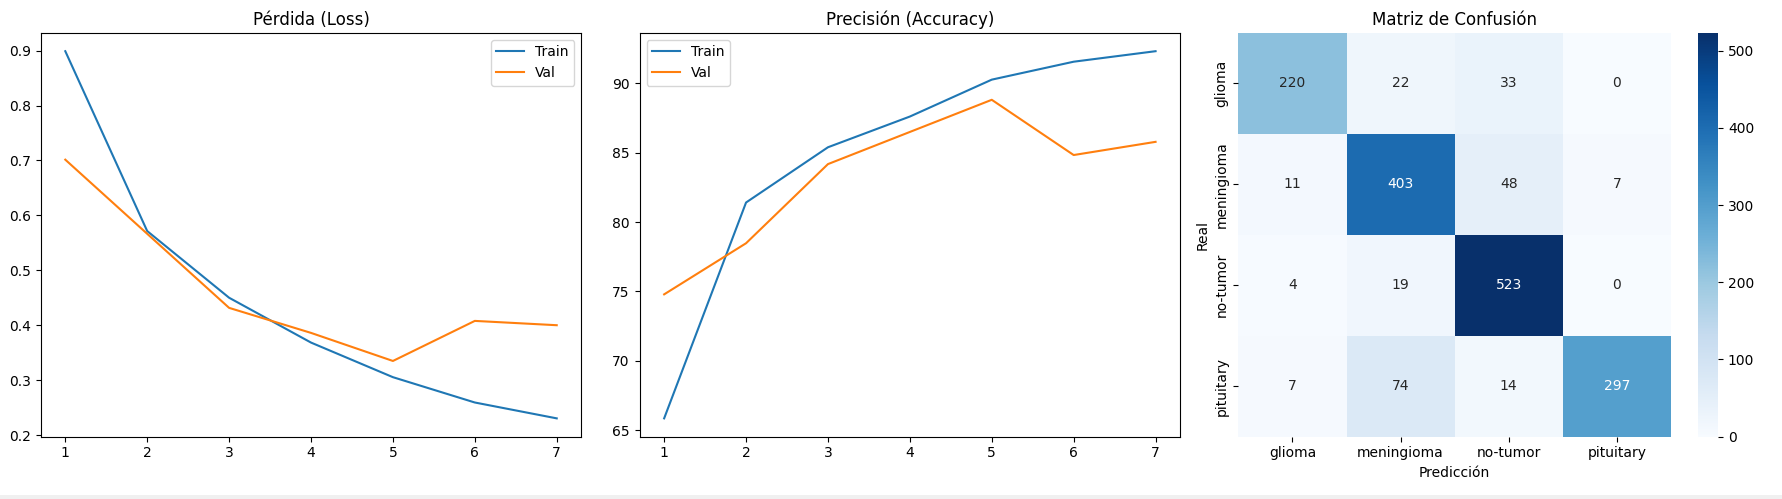

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# ==========================================
# FUNCIONES DE EVALUACIÓN Y ANÁLISIS
# ==========================================

def evaluate(model, test_loader):
    """Calcula la precisión (accuracy) de forma rápida."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total if total > 0 else 0.0

def train_with_validation(model, train_loader, dev_loader, criterion, optimizer, epochs=5):
    """Entrena el modelo y guarda el historial de Loss/Acc."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Usando dispositivo: {device}")
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': []}

    print(f"Iniciando entrenamiento en: {device}")

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Métricas de la época
        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # Validación
        model.eval()
        dev_loss_acc = 0.0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                dev_loss_acc += criterion(outputs, labels).item()

        avg_dev_loss = dev_loss_acc / len(dev_loader)
        dev_acc = evaluate(model, dev_loader)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        print(f'[Epoch {epoch + 1}] Loss: {avg_train_loss:.3f} | Train Acc: {train_acc:.2f}% | Val Acc: {dev_acc:.2f}%')

    return model, history

def analizar_resultados(model, history, test_loader, classes):
    """Dibuja Loss, Accuracy y Matriz de Confusión."""
    epochs = range(1, len(history['train_loss']) + 1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['dev_loss'], label='Val')
    plt.title('Pérdida (Loss)'); plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['dev_acc'], label='Val')
    plt.title('Precisión (Accuracy)'); plt.legend()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión')
    plt.ylabel('Real'); plt.xlabel('Predicción')

    plt.tight_layout()
    plt.show()

# ==========================================
# CONFIGURACIÓN Y EJECUCIÓN
# ==========================================

data_dir = "dataset"
NUM_CLASSES = 4

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datos
if not os.path.exists(data_dir):
    os.makedirs(os.path.join(data_dir, "glioma"), exist_ok=True)

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Aplicamos Wrapper para validación (opcional, aquí simplificado)
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Definición de Red
class CNN_Modificada(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_Modificada, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.Tanh(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.Tanh(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.Tanh(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.Tanh(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 512), nn.Tanh(), nn.Dropout(0.5),
            nn.Linear(512, 128), nn.Tanh(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = CNN_Modificada(NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scheduler.step()

# Entrenamiento usando las nuevas funciones
model_entrenado, historial = train_with_validation(
    model, train_loader, val_loader, criterion, optimizer, epochs=7
)

# Análisis visual
analizar_resultados(model_entrenado, historial, val_loader, full_dataset.classes)

# Guardado
torch.save(model_entrenado.state_dict(), "cnn_modificada.pth")
print("\nModelo y gráficas generadas con éxito.")